In [2]:

import numpy as np
import cv2 as cv
#import imageio
import glob
import matplotlib.pyplot as plt

im_paths = []
for im_path in glob.glob("/scratch/salik/ExtractedFlow/S001C001P001R001A001/*.png"):
    im_paths.append(im_path)
    #im = imageio.imread(im_path)
    #print(im_path)
     # do whatever with the image here
        
im_paths.sort()

#print(im_paths)

In [3]:
images = []
for path in im_paths:
    im = cv.imread(path)
    imnp = 

In [25]:
vis2 = cv.cvtColor(images[85], cv.COLOR_RGB2BGR)

(98, 1)


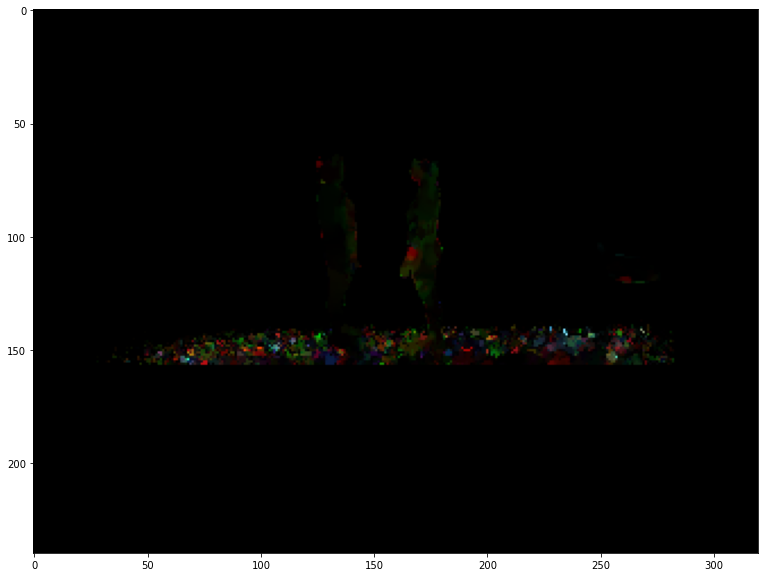

In [27]:
import numpy as np
import cv2 as cv
#import imageio
import glob
import matplotlib.pyplot as plt

#plot images as an animated video
import matplotlib.animation as animation
#%matplotlib inline


def visualize_3dflow(name):
    fig = plt.figure(figsize=(15,10))
    ims=[]
    images = []

    im_paths=[]
    for im_path in glob.glob("/scratch/salik/ExtractedFlow_masked/"+name+"/*.png"):
        im_paths.append(im_path)
    im_paths.sort()  

    for paths in im_paths:
        img = cv.imread(paths,cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        #print(np.shape(img))
        #img = cv.rectangle(img,(items['bbox'][0],items['bbox'][1]),(items['bbox'][2],items['bbox'][3]),(0,255,0),3)
        im = plt.imshow(img, animated=True)
        ims.append([im])
    
    print(np.shape(ims))


    ani = animation.ArtistAnimation(fig, ims, interval=41, blit=True,
                                    repeat_delay=1000,repeat=True)
    ani.save(name+'_.gif')
    plt.show()
    
visualize_3dflow('S001C001P001R001A001')

In [ ]:
import numpy as np
import cv2 as cv
#import imageio
import glob
import matplotlib.pyplot as plt

#plot images as an animated video
import matplotlib.animation as animation
#%matplotlib inline

def visualize_depth(name):
    fig = plt.figure(figsize=(15,10))
    ims=[]
    images = []

    im_paths=[]
    for im_path in glob.glob("/scratch/salik/NTU_RAW/DEPTH_masked_bright/"+name+"/*.png"):
        im_paths.append(im_path)
    im_paths.sort()  

    for paths in im_paths:
        img = cv.imread(paths,cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        #img = cv.rectangle(img,(items['bbox'][0],items['bbox'][1]),(items['bbox'][2],items['bbox'][3]),(0,255,0),3)
        im = plt.imshow(img, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=41, blit=True,
                                    repeat_delay=1000,repeat=False)
    ani.save('depth_'+name+'_.gif')
    plt.show()
    
visualize_depth('S001C001P001R001A001')

In [29]:
'''from ipywebrtc import VideoStream
video = VideoStream.from_file('depth_S001C001P001R001A002.mp4', play=True)
video'''

from ipywebrtc import VideoStream
video = VideoStream.from_file('depth_S001C001P001R001A001.gif', play=True)
video

VideoStream(video=Video(value=b'GIF89a8\x04\xd0\x02\xf7C\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x…

In [27]:
from ipywebrtc import VideoStream

video2 = VideoStream.from_url('depth_S001C001P001R001A001.gif')
video2

VideoStream(video=Video(value=b'depth_S001C001P001R001A001.gif', format='url'))

In [39]:
#!/usr/bin/env python3
import os
import h5py
import json
import time
import math
import argparse
import numpy as np
import collections

# Parameters
input_height = 240
input_width = 320

class Args:
    def __init__(self):
        self.top_dir = "/scratch/salik/ExtractedFlow_masked"
        self.videoname_json_path= "/home/salik/view-invariant-action/ntu_rgbd_videonames_reduced_S1.json"
        #self.output_dir = "/scratch/salik/3Dflows/"
        self.patch_size = 0
        self.num_worker = 0

def main():
  args = Args()

  if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

  with open(args.videoname_json_path, 'r') as fp:
    meta = json.load(fp, object_pairs_hook=collections.OrderedDict)

  videonames = meta['videonames']
  videonames = sorted(videonames)
  
  length = len(videonames)

  if args.num_worker < 1:
    for ind, videoname in enumerate(videonames):
      flow_text_to_h5(args, ind, videoname, length)
  else:
    from joblib import Parallel, delayed
    Parallel(n_jobs=args.num_worker)(
      delayed(flow_text_to_h5)(args, ind, videoname, length) for ind, videoname in enumerate(videonames)
      )

def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def timeSince(since):
  now = time.time()
  s = now - since
  return '%s' % (asMinutes(s))

def bin_ndarray(ndarray, new_shape, operation='sum'):
  """
  Bins an ndarray in all axes based on the target shape, by summing or
      averaging.

  Number of output dimensions must match number of input dimensions and 
      new axes must divide old ones.

  Example
  -------
  >>> m = np.arange(0,100,1).reshape((10,10))
  >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
  >>> print(n)

  [[ 22  30  38  46  54]
   [102 110 118 126 134]
   [182 190 198 206 214]
   [262 270 278 286 294]
   [342 350 358 366 374]]

  """
  operation = operation.lower()
  if not operation in ['sum', 'mean']:
    raise ValueError("Operation not supported.")
  if ndarray.ndim != len(new_shape):
    raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                         new_shape))
  compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                ndarray.shape)]
  flattened = [l for p in compression_pairs for l in p]
  ndarray = ndarray.reshape(flattened)
  for i in range(len(new_shape)):
    op = getattr(ndarray, operation)
    ndarray = op(-1*(i+1))
  return ndarray

def flow_text_to_h5(args, videoname_ind, videoname, length):
  start_time = time.time()
  video_dir = os.path.join(args.top_dir, videoname)
  files = os.listdir(video_dir)
  files = [os.path.join(video_dir, f) for f in files if f.startswith('3dflow_results') and f.endswith('.txt')]
  files = sorted(files)

  target_height = input_height
  target_width = input_width
  if args.patch_size > 0:
    target_height = input_height // args.patch_size
    target_width = input_width // args.patch_size

  #outfile_path = os.path.join(args.output_dir, videoname + '_3dflow.h5')
  #outfile = h5py.File(outfile_path, 'w')
  #dset = outfile.create_dataset('flow', 
  #  (len(files),target_height,target_width,3), 
  #  maxshape=(len(files),target_height,target_width,3), 
  #  chunks=True, dtype='f4')
  flows = []
  for f_ind, f in enumerate(files):
    # read jpeg as binary and put into h5
    flowtxt = np.loadtxt(f, dtype='f8')
    flow = flowtxt[:,2:5] # remove x, y coordinate speicified in text files
    flow = flow.reshape((input_height,input_width,3)) # 3 for x,y,z in 3d flow
    flow = bin_ndarray(flow, 
      new_shape=(target_height,target_width,3), 
      operation='mean'
      )
    flows[f_ind,:] = flow[:]

  #outfile.close()
  print('{}/{}. converting flows of {} to h5 done...{}'.format(
    videoname_ind+1, length, videoname, timeSince(start_time)) )
  
  return flows
    
    
def flow_text_to_numpy(args, videoname_ind, videoname, length):
  start_time = time.time()
  video_dir = os.path.join(args.top_dir, videoname)
  files = os.listdir(video_dir)
  files = [os.path.join(video_dir, f) for f in files if f.startswith('3dflow_results') and f.endswith('.txt')]
  files = sorted(files)

  target_height = input_height
  target_width = input_width
  if args.patch_size > 0:
    target_height = input_height // args.patch_size
    target_width = input_width // args.patch_size

  #outfile_path = os.path.join(args.output_dir, videoname + '_3dflow.h5')
  #outfile = h5py.File(outfile_path, 'w')
  #dset = outfile.create_dataset('flow', 
  #  (len(files),target_height,target_width,3), 
  #  maxshape=(len(files),target_height,target_width,3), 
  #  chunks=True, dtype='f4')
  #flows = []
  flows= np.zeros(shape=(len(files),target_height,target_width,3))
  for f_ind, f in enumerate(files):
    # read jpeg as binary and put into h5
    flowtxt = np.loadtxt(f, dtype='f8')
    flow = flowtxt[:,2:5] # remove x, y coordinate speicified in text files
    flow = flow.reshape((input_height,input_width,3)) # 3 for x,y,z in 3d flow
    flow = bin_ndarray(flow, 
      new_shape=(target_height,target_width,3), 
      operation='mean'
      )
    flows[f_ind,:] = flow[:]

 # outfile.close()
  print('{}/{}. converting flows of {} to h5 done...{}'.format(
    videoname_ind+1, length, videoname, timeSince(start_time)) )
  return flows
  

In [82]:
  args = Args()

  #if not os.path.isdir(args.output_dir):
  #  os.makedirs(args.output_dir)

  with open(args.videoname_json_path, 'r') as fp:
    meta = json.load(fp, object_pairs_hook=collections.OrderedDict)

  videonames = meta['videonames']
  videonames = sorted(videonames)
  
  length = len(videonames)
  flows = []
  flows = flow_text_to_numpy(args, 1, videonames[59], length)
  
  
  '''if args.num_worker < 1:
    for ind, videoname in enumerate(videonames):
      flows = flow_text_to_numpy(args, ind, videoname, length)
      break

  else:
    from joblib import Parallel, delayed
    Parallel(n_jobs=args.num_worker)(
      delayed(flow_text_to_numpy)(args, ind, videoname, length) for ind, videoname in enumerate(videonames)
      )'''

2/2880. converting flows of S001C001P001R001A060 to h5 done...0m 31s


'if args.num_worker < 1:\n  for ind, videoname in enumerate(videonames):\n    flows = flow_text_to_numpy(args, ind, videoname, length)\n    break\n\nelse:\n  from joblib import Parallel, delayed\n  Parallel(n_jobs=args.num_worker)(\n    delayed(flow_text_to_numpy)(args, ind, videoname, length) for ind, videoname in enumerate(videonames)\n    )'

In [83]:
np.shape(flows)

(92, 240, 320, 3)

In [84]:
videonames[59]

'S001C001P001R001A060'

In [85]:
def visualize_flow(name,flows):
    fig = plt.figure(figsize=(15,10))
    ims=[]

    for flow in flows:
        #print(np.shape(flow))
        #img = cv.imread(paths,cv.IMREAD_COLOR)
        #img = cv.cvtColor(flow, cv.COLOR_BGR2RGB)
        #img = cv.rectangle(img,(items['bbox'][0],items['bbox'][1]),(items['bbox'][2],items['bbox'][3]),(0,255,0),3)
        im = plt.imshow(abs((flow*10000).astype(int)), animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=41, blit=True,
                                    repeat_delay=1000,repeat=True)
    ani.save('flow_'+name+'_.gif')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

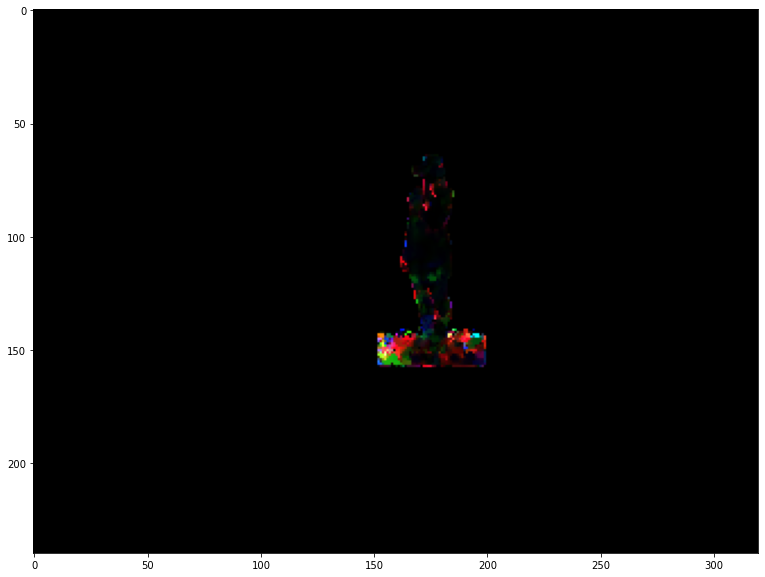

In [81]:
visualize_flow(videonames[59],flows)

In [69]:

flows.max()

0.458562